In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [8]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

--2024-10-12 18:14:06--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999,85K   906KB/s    in 1,1s    

2024-10-12 18:14:08 (906 KB/s) - ‘bank+marketing.zip’ saved [1023843]



In [10]:
!unzip bank.zip

Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [52]:
df = pd.read_csv("bank-full.csv", sep=";")
columns = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y"
]
df_full = df[columns]

## Question 1
- What is the most frequent observation (mode) for the column education?

In [53]:
df_full.education.mode()

0    secondary
Name: education, dtype: object

## Question 2

- Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

- What are the two features that have the biggest correlation?

In [54]:
df_num = df_full.select_dtypes(include='number')

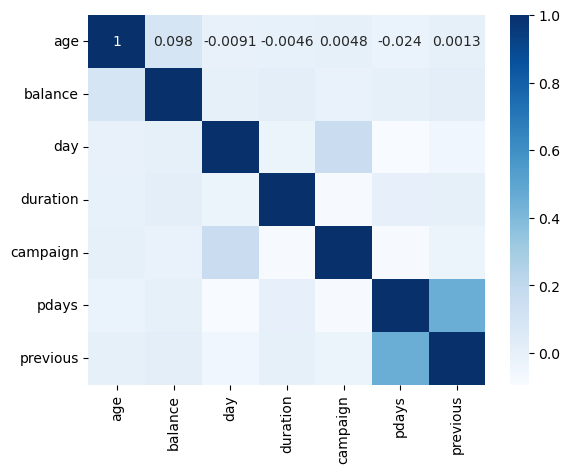

In [55]:
sns.heatmap(df_num.corr(), cmap="Blues", annot=True);

### Target encoding

In [56]:
df_full['y'] = df_full['y'].map({'yes': 1, 'no': 0})

/tmp/ipykernel_38828/2330532666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['y'] = df_full['y'].map({'yes': 1, 'no': 0})


### Split the data

In [58]:
df_full.y.unique()

array([0, 1])

In [59]:
train_full, test = train_test_split(df_full, random_state=42,  test_size=0.2)
train, val = train_test_split(train_full, random_state=42, test_size=0.25)

## Question 3

* Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
* Round the scores to 2 decimals using round(score, 2).

- Which of these variables has the biggest mutual information score?

In [60]:
df_cat = df_full.select_dtypes(exclude='number')

In [61]:
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,management,married,tertiary,yes,unknown,may,unknown
1,technician,single,secondary,yes,unknown,may,unknown
2,entrepreneur,married,secondary,yes,unknown,may,unknown
3,blue-collar,married,unknown,yes,unknown,may,unknown
4,unknown,single,unknown,no,unknown,may,unknown


In [62]:
for col in df_cat.columns:
    print(col)
    print(round(mutual_info_score(train_full[col], train_full["y"]), 2))

job
0.01
marital
0.0
education
0.0
housing
0.01
contact
0.01
month
0.02
poutcome
0.03


## Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    * To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    * model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

- What accuracy did you get?

In [72]:
y_train, y_val, y_test = train["y"], val["y"], test["y"]

In [101]:
dv = DictVectorizer(sparse=False)

In [102]:
dv.fit(train.to_dict(orient="records"))

DictVectorizer(sparse=False)

In [105]:
x_train = dv.transform(train.drop(columns=["y"]).to_dict(orient="records"))
x_val = dv.transform(val.drop(columns=["y"]).to_dict(orient="records"))
x_test = dv.transform(test.drop(columns=["y"]).to_dict(orient="records"))

In [116]:
lr = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [117]:
y_pred_val = lr.predict_proba(x_val)[:,1]
y_pred_val = (y_pred_val>=0.5).astype(int)
round((y_pred_val ==  y_val).mean(),2)
accuracy = (y_pred_val ==  y_val).mean()

## Question 5

* Let's find the least useful feature using the feature elimination technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

- Which of following feature has the smallest difference?

In [118]:
accuracy

0.9010174740101747

In [127]:
for i in range(len(dv.feature_names_)):
    if dv.feature_names_[i] in ['age', 'balance','marital=divorced', 'marital=married', 'marital=single', 'previous']:
        
        lr.fit(np.delete(x_train, i, 1), y_train)
    
        y_pred_val = lr.predict_proba(np.delete(x_val, i, 1))[:,1]
        y_pred_val = (y_pred_val>=0.5).astype(int)
        new_acc = (y_pred_val ==  y_val).mean()


        print(dv.feature_names_[i])
        print(np.abs(new_acc - accuracy))

age
0.0006635700066357497
balance
0.00022119000221187957
marital=divorced
0.0
marital=married
0.0001105950011059953
marital=single
0.00022119000221187957
previous
0.00044238000442375913


## Question 6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

- Which of these C leads to the best accuracy on the validation set?

In [133]:
for a in [0.01, 0.1, 1, 10, 100]:
    lr = LogisticRegression(solver="liblinear", C=a, max_iter=1000, random_state=42)
    lr.fit(x_train, y_train)
    y_pred_val = lr.predict_proba(x_val)[:,1]
    y_pred_val = (y_pred_val>=0.5).astype(int)
    print(a, "---> ",round((y_pred_val ==  y_val).mean(),3))

0.01 --->  0.898
0.1 --->  0.901
1 --->  0.901
10 --->  0.901
100 --->  0.901
